# Chapter 11. 離散値を取るパラメータを使う

## 11.1 離散パラメータを扱うテクニック

In [1]:
import pandas as pd
import numpy as np
import pystan
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

/Users/takashi_miyamoto/.pyenv/versions/anaconda3-2.1.0/lib/python3.4/site-packages/matplotlib/__init__.py:913: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


In [2]:
df_11_1 = pd.read_csv("input/data-coin.txt")
df_11_1.head()

,Y
0,1
1,0
2,1
3,0
4,0


In [3]:
data_11_1 = {'N':len(df_11_1['Y']), 'Y':df_11_1['Y'].values}

$$\begin{align*}
\text{coin}[n] &\sim \text{bernoulli}(0.5) \\
\theta[1] &= q \\
\theta[2] &= 1.0 \\
Y[n] &\sim \text{bernoulli}(\theta[\text{coin}[n]+1])
\end{align*}$$

$$p(Y|q) = 0.5 \;\text{bernoulli}(Y|q) + 
0.5 \;\text{bernoulli}(Y|1.0)$$

In [4]:
model_11_1 = """
data {
  int N;
  int<lower=0, upper=1> Y[N];
}

parameters {
  real<lower=0, upper=1> q;
}

model {
  for (n in 1:N)
    target += log_sum_exp(
      log(0.5) + bernoulli_lpmf(Y[n] | q),
      log(0.5) + bernoulli_lpmf(Y[n] | 1)
    );
}
"""

In [5]:
fit_11_1 = pystan.stan(model_code=model_11_1, data=data_11_1, iter=1000, chains=4)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_0bfe6cec067ad6186f06efd8a6c5efa4 NOW.


In [6]:
print(fit_11_1)

Inference for Stan model: anon_model_0bfe6cec067ad6186f06efd8a6c5efa4.
4 chains, each with iter=1000; warmup=500; thin=1; 
post-warmup draws per chain=500, total post-warmup draws=2000.

       mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
q      0.21  3.1e-3   0.09   0.03   0.14   0.21   0.27   0.39    872    1.0
lp__ -69.69    0.04   0.87 -72.43 -69.91 -69.35 -69.14 -69.08    453   1.01

Samples were drawn using NUTS at Wed May 17 17:27:41 2017.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).


In [7]:
df_11_2 = pd.read_csv("input/data-poisson-binomial.txt")
df_11_2.head()

,Y
0,6
1,5
2,8
3,2
4,5


In [8]:
data_11_2 = {'N':len(df_11_2['Y']), 'M_max':np.max(df_11_2['Y']), \
             'Y':df_11_2['Y'].values}

In [9]:
model_11_2 = """
data {
  int N;
  int M_max;
  int<lower=0> Y[N];
}

parameters {
  real<lower=0> lambda;
}

model {
  for (n in 1:N) {
    vector[M_max-Y[n]+1] lp;
    for (m in Y[n]:M_max)
      lp[m-Y[n]+1] = poisson_lpmf(m | lambda) + binomial_lpmf(Y[n] | m, 0.5);
    target += log_sum_exp(lp);
  }
}
"""

In [10]:
fit_11_2 = pystan.stan(model_code=model_11_2, data=data_11_2, iter=2000, chains=4)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_dfc8d249a66a3cb9aaf6b30732a141b2 NOW.


In [11]:
print(fit_11_2)

Inference for Stan model: anon_model_dfc8d249a66a3cb9aaf6b30732a141b2.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

         mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
lambda   7.29  5.8e-3    0.3   6.71   7.09    7.3   7.48   7.89   2718    1.0
lp__   -294.4    0.02   0.69 -296.4 -294.5 -294.1 -293.9 -293.9   1405    1.0

Samples were drawn using NUTS at Wed May 17 17:28:07 2017.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).


教科書の $\lambda \simeq 9.57$ にならない...

In [12]:
model_11_2b = """
data {
  int N;
  int M_max;
  int<lower=0> Y[N];
}

parameters {
  real<lower=0> lambda;
}

model {
  for (n in 1:N) {
    Y[n] ~ poisson(lambda*0.5);
  }
}
"""

In [13]:
fit_11_2b = pystan.stan(model_code=model_11_2b, data=data_11_2, iter=1000, chains=4)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_c3149595a299b58f044cd1680dc9c647 NOW.


In [14]:
print(fit_11_2b)

Inference for Stan model: anon_model_c3149595a299b58f044cd1680dc9c647.
4 chains, each with iter=1000; warmup=500; thin=1; 
post-warmup draws per chain=500, total post-warmup draws=2000.

         mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
lambda   9.62    0.01   0.44   8.79    9.3   9.62   9.95  10.52   1142    1.0
lp__   273.11    0.02    0.7 271.11 272.94 273.36 273.57 273.63    953    1.0

Samples were drawn using NUTS at Wed May 17 17:28:31 2017.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).


教科書の $\lambda \simeq 9.57$ 程度の値が出た。

## 11.2 混合正規分布

In [15]:
df_11_5 = pd.read_csv("input/data-mix1.txt")
df_11_5.head()

,Y
0,-0.84
1,-0.35
2,2.34
3,0.11
4,0.19


In [16]:
data_11_5 = {'N':len(df_11_5['Y']), 'Y':df_11_5['Y'].values}

教科書のmodelそのままだと全然収束しないので多少事前情報を与える。

In [17]:
model_11_5 = """
data {
  int N;
  vector[N] Y;
}

parameters {
  real<lower=0, upper=1> a;
  ordered[2] mu;
  vector<lower=0, upper=5.0>[2] sigma;
}

model {
  for (i in 1:2)
    target += normal_lpdf(mu | 3.0, 5.0);
  for (n in 1:N)
    target += log_sum_exp(
      log(a)   + normal_lpdf(Y[n] | mu[1], sigma[1]),
      log1m(a) + normal_lpdf(Y[n] | mu[2], sigma[2])
    );
}
"""

In [18]:
fit_11_5 = pystan.stan(model_code=model_11_5, data=data_11_5, iter=1000, chains=4)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_fed5ffb2e421258eaceca1c339f2b1cd NOW.


In [19]:
print(fit_11_5)

Inference for Stan model: anon_model_fed5ffb2e421258eaceca1c339f2b1cd.
4 chains, each with iter=1000; warmup=500; thin=1; 
post-warmup draws per chain=500, total post-warmup draws=2000.

           mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
a          0.54  2.5e-3   0.07   0.37   0.49   0.54   0.59   0.67    866    1.0
mu[0]     -0.05  6.9e-3   0.23  -0.48  -0.21  -0.05   0.11   0.41   1128    1.0
mu[1]      5.68    0.02   0.66   4.24   5.27   5.74   6.15   6.76    908    1.0
sigma[0]    1.3  5.8e-3   0.19   0.96   1.16   1.28   1.41   1.73   1135    1.0
sigma[1]   2.51    0.02   0.47   1.76   2.15   2.46    2.8   3.54    683    1.0
lp__     -260.1    0.07   1.79 -264.6 -261.0 -259.8 -258.8 -257.7    717    1.0

Samples were drawn using NUTS at Wed May 17 17:28:57 2017.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).


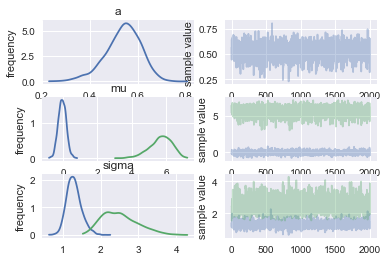

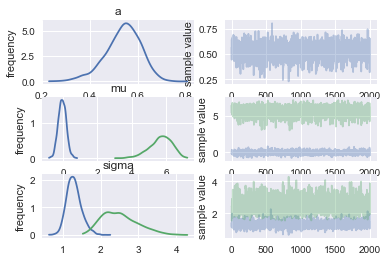

In [20]:
fit_11_5.plot()

In [21]:
df_11_6 = pd.read_csv("input/data-mix2.txt")
df_11_6.head()

,Y
0,9.44
1,9.77
2,11.56
3,10.07
4,10.13


In [22]:
data_11_6 = {'N':len(df_11_6['Y']), 'Y':df_11_6['Y'].values, 'K':5}

In [23]:
model_11_6b = """
functions {
  real normal_mixture_lpdf(real Y, int K, vector a, vector mu, vector sigma) {
    vector[K] lp;
    for (k in 1:K)
      lp[k] = log(a[k]) + normal_lpdf(Y | mu[k], sigma[k]);
    return log_sum_exp(lp);
  }
}

data {
  int N;
  int K;
  vector[N] Y;
}

parameters {
  simplex[K] a;
  ordered[K] mu;
  vector<lower=0>[K] sigma;
  real<lower=0> s_mu;
}

model {
  mu ~ normal(mean(Y), s_mu);
  sigma ~ gamma(1.5, 1);
  for (n in 1:N)
    Y[n] ~ normal_mixture(K, a, mu, sigma);
}
"""

In [24]:
fit_11_6b = pystan.stan(model_code=model_11_6b, data=data_11_6, iter=1000, chains=4)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_57b4275929f130a0ab88470a67383d3e NOW.


In [25]:
print(fit_11_6b)

Inference for Stan model: anon_model_57b4275929f130a0ab88470a67383d3e.
4 chains, each with iter=1000; warmup=500; thin=1; 
post-warmup draws per chain=500, total post-warmup draws=2000.

           mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
a[0]       0.17  6.1e-4   0.03   0.12   0.15   0.17   0.19   0.22   1943   1.01
a[1]       0.13    0.04   0.07   0.05   0.09   0.11   0.15   0.31      3    1.9
a[2]       0.31  5.8e-3   0.09   0.09   0.26   0.31   0.37   0.48    240    1.0
a[3]       0.24    0.03   0.11   0.03   0.17   0.24   0.32   0.46     11    1.1
a[4]       0.15  6.1e-3   0.07   0.04   0.11   0.14   0.17   0.34    117   1.03
mu[0]     10.01  4.5e-3   0.18   9.67   9.89  10.01  10.13  10.36   1518    1.0
mu[1]     17.27    1.49    2.1  15.38   15.9   16.2  19.38  21.01      2   5.82
mu[2]     21.08     0.3   0.51  20.64   20.8  20.91  21.08  22.77      3   1.47
mu[3]     23.55    0.06   1.08  22.07  22.94  23.48  23.96  25.16    369   1.01
mu[4]     30.

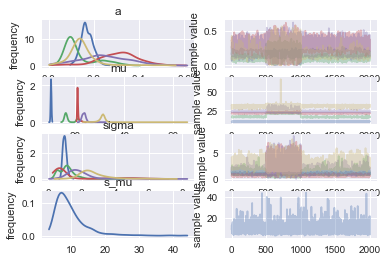

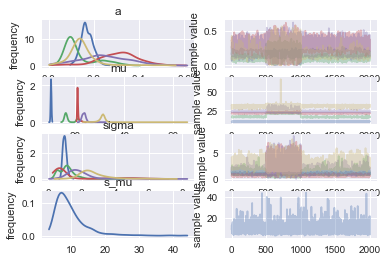

In [26]:
fit_11_6b.plot()

## 11.3 ゼロ過剰ポアソン分布

$$
\text{ZIP}(y|q,\lambda) = \left\{ \begin{array}{ccc}
\text{bernoulli}(0|q) \;+ & \text{bernoulli}(1|q) \times \text{poisson}(y|\lambda) & \text{if}\;\; y=0 \\
& \text{bernoulli}(1|q) \times \text{poisson}(y|\lambda) & \text{if}\;\; y\geq 1 \\
\end{array}\right.
$$

$$\begin{align*}
q[n] &= \text{inv_logit}((Xb_1)[n]) \\
\lambda[n] &= (Xb_2)[n] \\
Y[n] &\sim \text{ZIP}(q[n], \lambda[n])
\end{align*}$$

In [27]:
model_11_7 = """
functions {
  real ZIP_lpmf(int Y, real q, real lambda) {
    if (Y == 0) {
      return log_sum_exp(
        bernoulli_lpmf(0 | q),
        bernoulli_lpmf(1 | q) + poisson_log_lpmf(0 | lambda)
      );
    } else {
      return bernoulli_lpmf(1 | q) + poisson_log_lpmf(Y | lambda);
    }
  }
}

data {
  int N;
  int D;
  int<lower=0> Y[N];
  matrix[N,D] X;
}

parameters {
  vector[D] b[2];
}

transformed parameters {
  vector[N] q_x;
  vector[N] q;
  vector[N] lambda;

  q_x = X*b[1];
  lambda = X*b[2];
  for (n in 1:N)
    q[n] = inv_logit(q_x[n]);
}

model {
  for (n in 1:N)
    Y[n] ~ ZIP(q[n], lambda[n]);
}
"""

In [28]:
df_11_7 = pd.read_csv("input/data-ZIP.txt")
df_11_7.head()

,Sex,Sake,Age,Y
0,0,1,18,5
1,1,0,18,2
2,1,1,18,1
3,0,0,19,3
4,0,0,19,5


In [29]:
data_11_7 = {'N':len(df_11_7['Y']), 'D':4, 'Y':df_11_7['Y'], \
             'X':[[1.0, sex, sake, age] for (sex,sake,age) in \
                  zip(df_11_7['Sex'].values, df_11_7['Sake'].values, df_11_7['Age'].values)]}
                     

In [30]:
fit_11_7 = pystan.stan(model_code=model_11_7, data=data_11_7, iter=1000, chains=4)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_5a7a10f9948c1c422c1ef9c8de84f6de NOW.


In [31]:
print(fit_11_7)

Inference for Stan model: anon_model_5a7a10f9948c1c422c1ef9c8de84f6de.
4 chains, each with iter=1000; warmup=500; thin=1; 
post-warmup draws per chain=500, total post-warmup draws=2000.

              mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
b[0,0]        0.94    0.02   0.69  -0.45    0.5   0.94   1.41   2.27   1217    1.0
b[1,0]        1.45  3.3e-3   0.13   1.19   1.36   1.45   1.54   1.71   1670    1.0
b[0,1]        1.59    0.01   0.42    0.8    1.3   1.58   1.87   2.43   1338    1.0
b[1,1]       -0.75  1.8e-3   0.08   -0.9   -0.8  -0.74   -0.7  -0.58   1999    1.0
b[0,2]        3.35    0.03   0.85   1.98   2.77   3.22    3.8   5.35    961    1.0
b[1,2]       -0.16  1.6e-3   0.07   -0.3  -0.21  -0.16  -0.11  -0.02   2000    1.0
b[0,3]       -0.04  5.1e-4   0.02  -0.07  -0.05  -0.04  -0.02-7.4e-4   1286    1.0
b[1,3]        0.02  8.2e-5 3.4e-3   0.01   0.02   0.02   0.02   0.03   1695    1.0
q_x[0]        3.63    0.03   0.91   2.16   2.99   3.54   4.16   5.

In [32]:
df = pd.read_csv("input/data-ZIP.txt")
df['lambda'] = [np.average(xs) for xs in fit_11_7.extract(permuted=True)['lambda'].T]
df['q'] = [np.average(xs) for xs in fit_11_7.extract(permuted=True)['q'].T]

[]

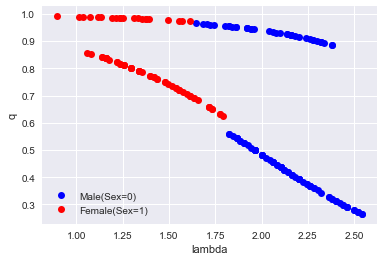

In [33]:
plt.plot(df[df['Sex']==0]['lambda'], df[df['Sex']==0]['q'], 'bo', label='Male(Sex=0)')
plt.plot(df[df['Sex']==1]['lambda'], df[df['Sex']==1]['q'], 'ro', label='Female(Sex=1)')
plt.legend(loc='best')
plt.xlabel('lambda')
plt.ylabel('q')
plt.plot()

[]

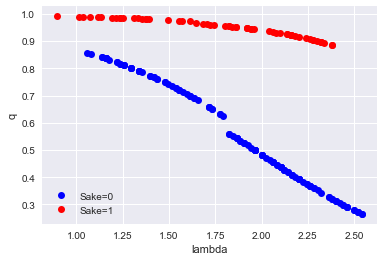

In [34]:
plt.plot(df[df['Sake']==0]['lambda'], df[df['Sake']==0]['q'], 'bo', label='Sake=0')
plt.plot(df[df['Sake']==1]['lambda'], df[df['Sake']==1]['q'], 'ro', label='Sake=1')
plt.legend(loc='best')
plt.xlabel('lambda')
plt.ylabel('q')
plt.plot()

## 11.4 Latent Dirichlet Allocation

In [35]:
df_11_8 = pd.read_csv("input/data-lda.txt")
df_11_8.head()

,PersonID,ItemID
0,1,105
1,1,80
2,1,54
3,1,120
4,1,6


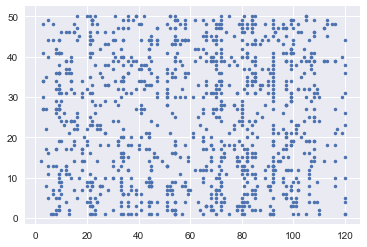

In [36]:
plt.plot(df_11_8['ItemID'], df_11_8['PersonID'], '.')

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x11b485160>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x1216bd048>]], dtype=object)

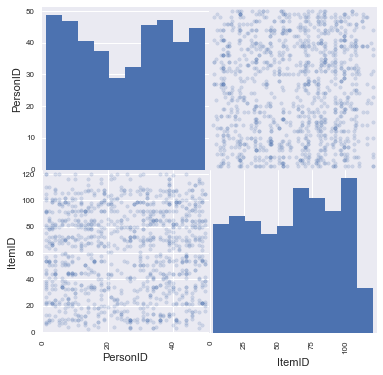

In [37]:
from pandas.tools.plotting import scatter_matrix
scatter_matrix(df_11_8, alpha=0.2, figsize=(6, 6))

$$\begin{align*}
\text{dice} &\sim \text{Categorical}(\vec{\theta}[n]) \\
y &\sim \text{Categorical}(\vec{\phi}[\text{dice}]) \\
p(y | \vec{\theta}[n], \vec{\phi}[1], \dots, \vec{\phi}[K]) &= \sum_{k=1}^K \theta[n,k] \phi[k,y] \\
&= \text{CateCate}(\vec{\theta}[n], \vec{\phi}[1], \dots, \vec{\phi}[K]) \\
\text{ItemID}[e] &\sim \text{CateCate}(\vec{\theta}[\text{PersonID}[e], \vec{\phi}[1], \dots, \vec{\phi}[K]) \\
\vec{\phi}[k] &\sim \text{Dirichlet}(\alpha)
\end{align*}$$

In [38]:
model_11_8 = """
functions {
  real CateCate_lpmf(int Y, int K, vector theta, vector[] phi) {
    vector[K] lp;
    for (k in 1:K)
      lp[k] = log(theta[k]) + log(phi[k,Y]);
    return log_sum_exp(lp);
  }
}

data {
  int<lower=1> E;
  int<lower=1> N;
  int<lower=1> I;
  int<lower=1> K;
  int<lower=1, upper=N> PersonID[E];
  int<lower=1, upper=I> ItemID[E];
  vector<lower=0>[I] Alpha;
}

parameters {
  simplex[K] theta[N];
  simplex[I] phi[K];
}

model {
  for (k in 1:K)
    phi[k] ~ dirichlet(Alpha);
  for (e in 1:E)
    ItemID[e] ~ CateCate(K, theta[PersonID[e]], phi);
}
"""

In [39]:
data_11_8 = {'E':len(df_11_8['ItemID']), \
             'N':50, 'I':120, 'K':6, \
             'PersonID':df_11_8['PersonID'].values, \
             'ItemID':df_11_8['ItemID'].values, \
             'Alpha':np.ones(120)*0.5}
                     
             

In [40]:
np.ones(10)

array([ 1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.])

PyStanは変分ベイズ未対応なので回数を増やして普通にやってみたが、全然ダメっぽい。

In [41]:
from pystan.model import StanModel
sm = StanModel(model_code=model_11_8)
#fit_11_8 = sm.vb(data=data_11_8)
fit_11_8 = pystan.stan(model_code=model_11_8, data=data_11_8, iter=1000, chains=4)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_3b3b4072fb36aff2ca22bf4cb4889c90 NOW.
INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_3b3b4072fb36aff2ca22bf4cb4889c90 NOW.


In [42]:
print(fit_11_8)

Inference for Stan model: anon_model_3b3b4072fb36aff2ca22bf4cb4889c90.
4 chains, each with iter=1000; warmup=500; thin=1; 
post-warmup draws per chain=500, total post-warmup draws=2000.

              mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
theta[0,0]    0.17  4.5e-3   0.13 5.8e-3   0.06   0.13   0.24    0.5    886    1.0
theta[1,0]    0.17  5.9e-3   0.14 5.4e-3   0.06   0.13   0.24   0.51    548   1.01
theta[2,0]    0.16  7.1e-3   0.15 6.1e-3   0.05   0.12   0.24   0.55    413   1.01
theta[3,0]    0.17  5.2e-3   0.13 6.8e-3   0.06   0.13   0.23    0.5    638    1.0
theta[4,0]    0.16  3.0e-3   0.13 6.8e-3   0.06   0.13   0.24   0.49   2000    1.0
theta[5,0]    0.18    0.01   0.15 4.8e-3   0.06   0.13   0.26   0.56    191   1.03
theta[6,0]    0.17  5.3e-3   0.15 5.1e-3   0.05   0.13   0.25   0.56    762    1.0
theta[7,0]    0.16  6.6e-3   0.14 3.7e-3   0.05   0.12   0.23   0.52    474    1.0
theta[8,0]    0.16  4.3e-3   0.13 5.3e-3   0.05   0.12   0.23    0

## 演習問題

### (4)
モデル式
$$\begin{align*}
m &\sim \text{poisson}(\lambda) \\
\vec{Y} &\sim \text{multinominal}(m, \vec{p})
\end{align*}$$
と
$$Y_i \sim \text{poisson}(\lambda p_i)$$
が等しいことを示せ。
ただし、$\forall i, p_i \geq 0$ かつ $\sum_i p_i = 1$




$Y_i$ 以外の $\{Y_j\}_{j\neq i}$ について周辺化した場合を考える。
$\sum_i Y_i = m$で、$i$のケースが$Y_i$回起きたとすると、$\{j\}_{j\neq i}$のケースが$m-Y_i$回起きている。
従って、$Y_i \sim \text{binom}(m, p_i)$ となる。

$$\begin{align*}
p(Y_i | \lambda, p_i) &= \sum_{m=0}^\infty p(m|\lambda) p(Y_i|m, p_i) \\
&= \sum_{m=0}^\infty e^{-\lambda} \frac{\lambda^m}{m!} \frac{m!}{Y_i ! (m-Y_i)!}p_i^{Y_i}(1-p_i)^{(m-Y_i)} \\
&= e^{-\lambda} \frac{(\lambda p_i)^{Y_i}}{Y_i !} \sum_{m=0}^\infty 
\frac{(\lambda - \lambda p_i)^{m-Y_i}}{(m-Y_i)!} \\
&= e^{-\lambda p_i} \frac{(\lambda p_i)^{Y_i}}{Y_i !} \times e^{\lambda p_i}e^{-\lambda}e^{\lambda - \lambda p_i}\\
&= \text{poisson}(Y_i|\lambda p_1)
\end{align*}$$
